In [1]:
import pickle

In [2]:
with open('/project_final/orbitals.pkl', 'rb') as f:
    orbitals = pickle.load(f)

with open('/project_final/maneuvers.pkl', 'rb') as f:
    maneuvers = pickle.load(f)

In [3]:
man_s3a = maneuvers['s3a']
man_fy2d = maneuvers['FY2D']
man_saral = maneuvers['srl']

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
xgb_s3a_df = pd.read_csv("/project_final/result/s3a_xgb_residuals.csv", parse_dates=["day_time"])
xgb_diff_s3a_df = pd.read_csv("/project_final/result/s3a_xgb_residuals_diff.csv", parse_dates=["day_time"])
xgb_fy2d_df = pd.read_csv("/project_final/result/fy2d_xgb_residuals.csv", parse_dates=["day_time"])
xgb_diff_fy2d_df = pd.read_csv("/project_final/result/fy2d_xgb_residuals_diff.csv", parse_dates=["day_time"])
xgb_saral_df = pd.read_csv("/project_final/result/saral_xgb_residuals.csv", parse_dates=["day_time"])
xgb_diff_saral_df = pd.read_csv("/project_final/result/saral_xgb_residuals_diff.csv", parse_dates=["day_time"])

In [6]:
xgb_s3a_df.rename(columns={"day_time": "date"}, inplace=True)
xgb_diff_s3a_df.rename(columns={"day_time": "date"}, inplace=True)
xgb_fy2d_df.rename(columns={"day_time": "date"}, inplace=True)
xgb_diff_fy2d_df.rename(columns={"day_time": "date"}, inplace=True)
xgb_saral_df.rename(columns={"day_time": "date"}, inplace=True)
xgb_diff_saral_df.rename(columns={"day_time": "date"}, inplace=True)

xgb_s3a_df.drop(columns=['actual','pred'],inplace=True)
xgb_diff_s3a_df.drop(columns=['actual','pred'],inplace=True)
xgb_fy2d_df.drop(columns=['actual','pred'],inplace=True)
xgb_diff_fy2d_df.drop(columns=['actual','pred'],inplace=True)
xgb_saral_df.drop(columns=['actual','pred'],inplace=True)
xgb_diff_saral_df.drop(columns=['actual','pred'],inplace=True)

In [7]:
import numpy as np

In [8]:
results = [xgb_s3a_df, xgb_diff_s3a_df, xgb_fy2d_df, xgb_diff_fy2d_df, xgb_saral_df, xgb_diff_saral_df]

for df in results:
    df['residual'].update(df['residual'].abs())

In [9]:
print(xgb_s3a_df.head(1), "\n", xgb_diff_s3a_df.head(1), "\n", xgb_fy2d_df.head(1), "\n", xgb_diff_fy2d_df.head(1), "\n", xgb_saral_df.head(1), "\n", xgb_diff_saral_df.head(1))

        date  residual
0 2016-03-07  0.003524 
         date  residual
0 2016-03-12  0.082285 
         date  residual
0 2011-02-02  0.001062 
         date  residual
0 2011-02-01  0.141243 
         date  residual
0 2013-03-18  0.004952 
         date  residual
0 2013-03-17   1.47788


In [10]:
xgb_s3a_df = xgb_s3a_df[5:]
xgb_diff_s3a_df = xgb_diff_s3a_df
xgb_fy2d_df
xgb_diff_fy2d_df = xgb_diff_fy2d_df[1:]
xgb_saral_df
xgb_diff_saral_df = xgb_diff_saral_df[1:]

## man align with res abs

In [11]:
man_dates_s3a = pd.to_datetime(man_s3a["median_day_time"])
man_dates_s3a = man_dates_s3a.sort_values()

man_dates_fy2d = pd.to_datetime(man_fy2d["median_day_time"])
man_dates_fy2d = man_dates_fy2d.sort_values()

man_dates_saral = pd.to_datetime(man_saral["median_day_time"])
man_dates_saral = man_dates_saral.sort_values()

In [12]:
man_dates_s3a = man_dates_s3a[6:-1]
man_dates_fy2d = man_dates_fy2d[1:]
man_dates_saral = man_dates_saral[7:-1]

## threshold

In [13]:
def convert_timestamp_series_to_epoch(series):
    return (
        (series - pd.Timestamp(year=1970, month=1, day=1)) // pd.Timedelta(seconds=1)
    ).values

In [14]:
def compute_simple_matching_precision_recall_for_one_threshold(
    matching_max_days,
    threshold,
    series_ground_truth_manoeuvre_timestamps,
    series_predictions,
):
    matching_max_distance_seconds = pd.Timedelta(days=matching_max_days).total_seconds()
    dict_predictions_to_ground_truth = {}
    dict_ground_truth_to_predictions = {}

    manoeuvre_timestamps_seconds = convert_timestamp_series_to_epoch(series_ground_truth_manoeuvre_timestamps)
    pred_time_stamps_seconds = convert_timestamp_series_to_epoch(series_predictions.index)
    predictions = series_predictions.to_numpy()

    for i in range(predictions.shape[0]):
        if predictions[i] >= threshold:
            left_index = np.searchsorted(
                manoeuvre_timestamps_seconds, pred_time_stamps_seconds[i]
            )

            if left_index != 0:
                left_index -= 1

            index_of_closest = left_index

            if (left_index < len(series_ground_truth_manoeuvre_timestamps) - 1) and (
                abs(manoeuvre_timestamps_seconds[left_index] - pred_time_stamps_seconds[i])
                > abs(manoeuvre_timestamps_seconds[left_index + 1] - pred_time_stamps_seconds[i])
            ):
                index_of_closest = left_index + 1

            diff = abs(manoeuvre_timestamps_seconds[index_of_closest] - pred_time_stamps_seconds[i])

            if diff < matching_max_distance_seconds:
                dict_predictions_to_ground_truth[i] = (index_of_closest, diff)
                if index_of_closest in dict_ground_truth_to_predictions:
                    dict_ground_truth_to_predictions[index_of_closest].append(i)
                else:
                    dict_ground_truth_to_predictions[index_of_closest] = [i]

    positive_prediction_indices = np.argwhere(predictions >= threshold)[:, 0]
    list_false_positives = [
        pred_ind for pred_ind in positive_prediction_indices if pred_ind not in dict_predictions_to_ground_truth
    ]
    list_false_negatives = [
        true_ind for true_ind in np.arange(0, len(series_ground_truth_manoeuvre_timestamps))
        if true_ind not in dict_ground_truth_to_predictions
    ]

    precision = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_positives)) if (len(dict_ground_truth_to_predictions) + len(list_false_positives)) > 0 else 0.0
    recall = len(dict_ground_truth_to_predictions) / (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) if (len(dict_ground_truth_to_predictions) + len(list_false_negatives)) > 0 else 0.0

    return (precision, recall)

In [15]:
s3a_thresholds = np.sort(xgb_s3a_df['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
s3a_precision_3d, s3a_recall_3d = [], []

for threshold in s3a_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_s3a,
        series_predictions=xgb_s3a_df.set_index("date")["residual"]
    )
    s3a_precision_3d.append(p)
    s3a_recall_3d.append(r)
    
s3a_diff_thresholds = np.sort(xgb_diff_s3a_df['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
s3a_diff_precision_3d, s3a_diff_recall_3d = [], []

for threshold in s3a_diff_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_s3a,
        series_predictions=xgb_diff_s3a_df.set_index("date")["residual"]
    )
    s3a_diff_precision_3d.append(p)
    s3a_diff_recall_3d.append(r)

In [16]:
fy2d_thresholds = np.sort(xgb_fy2d_df['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
fy2d_precision_3d, fy2d_recall_3d = [], []

for threshold in fy2d_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_fy2d,
        series_predictions=xgb_fy2d_df.set_index("date")["residual"]
    )
    fy2d_precision_3d.append(p)
    fy2d_recall_3d.append(r)
    
fy2d_diff_thresholds = np.sort(xgb_diff_fy2d_df['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
fy2d_diff_precision_3d, fy2d_diff_recall_3d = [], []

for threshold in fy2d_diff_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_fy2d,
        series_predictions=xgb_diff_fy2d_df.set_index("date")["residual"]
    )
    fy2d_diff_precision_3d.append(p)
    fy2d_diff_recall_3d.append(r)

In [17]:
saral_thresholds = np.sort(xgb_saral_df['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
saral_precision_3d, saral_recall_3d = [], []

for threshold in saral_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_saral,
        series_predictions=xgb_saral_df.set_index("date")["residual"]
    )
    saral_precision_3d.append(p)
    saral_recall_3d.append(r)
    
saral_diff_thresholds = np.sort(xgb_diff_saral_df['residual'].unique()) # np.linspace(6e-9, 6e-5, 1000)

# Compute LSTM PR curves for 3, 4, and 5 day windows
saral_diff_precision_3d, saral_diff_recall_3d = [], []

for threshold in saral_diff_thresholds:
    
    # 2-day
    p, r = compute_simple_matching_precision_recall_for_one_threshold(
        matching_max_days=3.0,
        threshold=threshold,
        series_ground_truth_manoeuvre_timestamps=man_dates_saral,
        series_predictions=xgb_diff_saral_df.set_index("date")["residual"]
    )
    saral_diff_precision_3d.append(p)
    saral_diff_recall_3d.append(r)

### F1

In [18]:
def find_best_f1(thresholds, precision_list, recall_list):
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0.0 for p, r in zip(precision_list, recall_list)]
    max_index = int(np.argmax(f1_scores))
    return (
        thresholds[max_index],      # 
        f1_scores[max_index],       # 
        precision_list[max_index],  
        recall_list[max_index]      
    )

In [19]:
s3a_best_thr_3d, s3a_best_f2_3d, s3a_best_p_3d, s3a_best_r_3d = find_best_f1(s3a_thresholds, s3a_precision_3d, s3a_recall_3d)
s3a_diff_best_thr_3d, s3a_diff_best_f2_3d, s3a_diff_best_p_3d, s3a_diff_best_r_3d = find_best_f1(s3a_diff_thresholds, s3a_diff_precision_3d, s3a_diff_recall_3d)
fy2d_best_thr_3d, fy2d_best_f2_3d, fy2d_best_p_3d, fy2d_best_r_3d = find_best_f1(fy2d_thresholds, fy2d_precision_3d, fy2d_recall_3d)
fy2d_diff_best_thr_3d, fy2d_diff_best_f2_3d, fy2d_diff_best_p_3d, fy2d_diff_best_r_3d = find_best_f1(fy2d_diff_thresholds, fy2d_diff_precision_3d, fy2d_diff_recall_3d)
saral_best_thr_3d, saral_best_f2_3d, saral_best_p_3d, saral_best_r_3d = find_best_f1(saral_thresholds, saral_precision_3d, saral_recall_3d)
saral_diff_best_thr_3d, saral_diff_best_f2_3d, saral_diff_best_p_3d, saral_diff_best_r_3d = find_best_f1(saral_diff_thresholds, saral_diff_precision_3d, saral_diff_recall_3d)

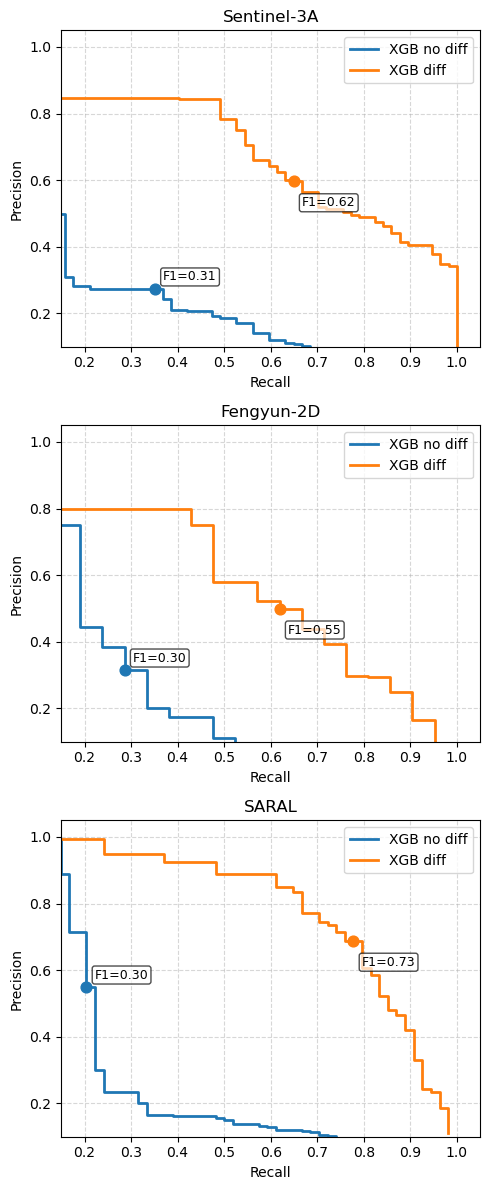

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def clean_pr(recall, precision, thresholds=None, drop_last=True, clip_max=0.995,
             enforce_monotone=True):
    r = np.asarray(recall, dtype=float)
    p = np.asarray(precision, dtype=float)
    t = None if thresholds is None else np.asarray(thresholds, dtype=float)

    if drop_last and len(r) > 1:
        r, p = r[:-1], p[:-1]
        if t is not None and len(t) >= len(r):
            t = t[:len(r)]

    order = np.argsort(r)
    r, p = r[order], p[order]
    if t is not None:
        t = t[order]

    
    ur, idx = np.unique(r, return_index=True)
    
    max_p = []
    pick_t = [] if t is not None else None
    for i, rr in enumerate(ur):
        mask = (r == rr)
        p_grp = p[mask]
        j = np.argmax(p_grp)
        max_p.append(p_grp[j])
        if t is not None:
            pick_t.append(t[mask][j])
    r, p = ur, np.array(max_p)
    if t is not None:
        t = np.array(pick_t)

    if clip_max is not None:
        p = np.clip(p, 0.0, clip_max)

    if enforce_monotone and len(p) > 1:
        
        p = np.maximum.accumulate(p[::-1])[::-1]

    return r, p, t

def best_f1_idx(precision, recall):
    p = np.asarray(precision, dtype=float)
    r = np.asarray(recall, dtype=float)
    denom = p + r
    f1 = np.where(denom > 0, 2 * p * r / denom, 0.0)
    
    m = np.nanmax(f1)
    cand = np.flatnonzero(f1 == m)
    if len(cand) > 1:
        cand = cand[np.argmax(r[cand])]
    else:
        cand = int(cand[0])
    return cand, f1

def plot_pr_pair(ax, rec_a, prec_a, thr_a, label_a,
                 rec_b, prec_b, thr_b, label_b,
                 step=True, show_best=True, marker_size=60):

    ra, pa, ta = clean_pr(rec_a, prec_a, thr_a)
    rb, pb, tb = clean_pr(rec_b, prec_b, thr_b)

    ds = "steps-post" if step else None
    ax.plot(ra, pa, lw=2, label=label_a, drawstyle=ds)
    ax.plot(rb, pb, lw=2, label=label_b, drawstyle=ds)

    if show_best:
        ia, f1a = best_f1_idx(pa, ra)
        ib, f1b = best_f1_idx(pb, rb)
        ax.scatter(ra[ia], pa[ia], s=marker_size, zorder=5)
        ax.scatter(rb[ib], pb[ib], s=marker_size, zorder=5)
        ax.annotate(f"F1={f1a[ia]:.2f}", (ra[ia], pa[ia]),
                    xytext=(6, 6), textcoords="offset points",
                    fontsize=9, bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7))
        ax.annotate(f"F1={f1b[ib]:.2f}", (rb[ib], pb[ib]),
                    xytext=(6, -18), textcoords="offset points",
                    fontsize=9, bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.7))

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0.15, 1.05)
    ax.set_ylim(0.1, 1.05)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(loc="upper right", fontsize=10)

fig, axes = plt.subplots(3, 1, figsize=(5, 12), sharex=False, sharey=False)

# Sentinel-3A
plot_pr_pair(
    axes[0],
    s3a_recall_3d, s3a_precision_3d, globals().get("s3a_thresholds_3d", None), "XGB no diff",
    s3a_diff_recall_3d, s3a_diff_precision_3d, globals().get("s3a_diff_thresholds_3d", None), "XGB diff",
)
axes[0].set_title("Sentinel-3A")

# Fengyun-2D
plot_pr_pair(
    axes[1],
    fy2d_recall_3d, fy2d_precision_3d, globals().get("fy2d_thresholds_3d", None), "XGB no diff",
    fy2d_diff_recall_3d, fy2d_diff_precision_3d, globals().get("fy2d_diff_thresholds_3d", None), "XGB diff",
)
axes[1].set_title("Fengyun-2D")

# SARAL
plot_pr_pair(
    axes[2],
    saral_recall_3d, saral_precision_3d, globals().get("saral_thresholds_3d", None), "XGB no diff",
    saral_diff_recall_3d, saral_diff_precision_3d, globals().get("saral_diff_thresholds_3d", None), "XGB diff",
)
axes[2].set_title("SARAL")

plt.tight_layout()
plt.show()
